In this notebook I compute the frequency of which pixels exceed certain precipitation intensity threshold. This could be an indication 

In [1]:
from os import listdir
from os.path import isfile, join
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from tqdm import tqdm

from PIL import Image, ImageDraw

import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import cv2
import radarplot
import netCDF4
from matplotlib.patches import Rectangle

from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap
import scipy.ndimage

from skimage import morphology

Pysteps configuration file found at: /usr/people/schreurs/.local/lib/python3.9/site-packages/pysteps/pystepsrc



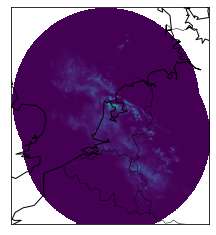

In [5]:
radarplot.plot_on_map(np.load(radar_dir+'201906060000.npy'), ftype='.h5', colorbar=False)

In [7]:
import config

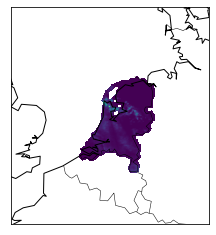

In [10]:
radarplot.plot_on_map(np.load(config.dir_aart_npy+'201906060000.npy'), ftype='.nc', colorbar=False)

In [3]:
radar_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_radar_np/'
files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f)) and f.startswith('2019')])
print(len(files))

103853


In [5]:
# Threshold values in 0.01mm
# 0.3mm, 3mm, 30mm, 100mm (50dBZ) heavy rain/small hail, 200mm (~60dBZ) extreme hail
thresholds = [30, 300, 3000, 10000, 20000] 

In [331]:
np.random.seed(0)
random_files = np.random.choice(files, 20000)

In [5]:
label_dir = '/nobackup_1/users/schreurs/project_GAN/rtcor_rain_labels'
labels = sorted([f for f in listdir(label_dir) if isfile(join(label_dir, f)) and f.startswith('2019')])
rainy_samples=[]
nonrainy_samples=[]

for label in tqdm(labels):
    rainy = np.load(label_dir+label)
    if rainy:
        rainy_samples.append(label)
    else:
        nonrainy_samples.append(label)
print('{:.2f}% of the samples are labeled as rainy'.format(100*len(rainy_samples)/len(labels)))

100%|██████████| 103853/103853 [00:38<00:00, 2670.18it/s]

31.04% of the samples are labeled as rainy


In [119]:
def filter_clutter(img, threshold=30):
    '''
    Removes isolated pixels. Pixel is isolated if it has rain but no rainy neighbours.
    img: image to be preprocessed
    threshold: threshold for rain no rain, default is 0.3mm (30)
    '''
    rainy = (img > threshold).astype('uint8')
    # Set pixels below threshold to 0
    preprocessed = img*rainy
    
    # Create kernel that checks if pixel has no rainy neighbours
    kernel_size=3
    kernel = -np.ones((kernel_size,kernel_size))
    kernel[1,1] = 1
    
    # Move kernel over image
    isolated_pixels = cv2.morphologyEx(rainy, cv2.MORPH_HITMISS, kernel)
    # Remove isolated pixels 
    output = preprocessed * np.logical_not(isolated_pixels)
    
    return output


In [7]:
count_exceed = np.zeros((len(thresholds), 765,700))
count_sum = 0
error_count=0
max_val = 0

for f in tqdm(files):
    try:
        rdr = np.load(radar_dir+f)
        rdr[rdr == 65535] = 0
        if rdr[0][0] != 0:
            print(rdr[0][0])
        cleaned = morphology.remove_small_objects(rdr>0, min_size=9, connectivity=8)   
        rdr = rdr*cleaned
    except Exception as e:
        print(e)
        error_count=+1
        rdr = np.zeros((765,700))
        
    for i, thresh in enumerate(thresholds):
        count_exceed[i] += rdr>thresh
    if np.max(rdr) > max_val:
        max_val=np.max(rdr)
    count_sum += 1


 25%|██▌       | 26023/103853 [08:23<25:23, 51.08it/s]

Object arrays cannot be loaded when allow_pickle=False


 26%|██▌       | 26683/103853 [08:36<23:22, 55.01it/s]

Object arrays cannot be loaded when allow_pickle=False


 27%|██▋       | 27665/103853 [08:54<21:15, 59.72it/s]

Object arrays cannot be loaded when allow_pickle=False


 28%|██▊       | 29516/103853 [09:30<22:28, 55.12it/s]

Object arrays cannot be loaded when allow_pickle=False


 35%|███▌      | 36595/103853 [11:47<24:39, 45.47it/s]

Object arrays cannot be loaded when allow_pickle=False


 56%|█████▋    | 58474/103853 [18:35<14:03, 53.82it/s]

Object arrays cannot be loaded when allow_pickle=False


 57%|█████▋    | 58967/103853 [18:43<14:25, 51.88it/s]

Object arrays cannot be loaded when allow_pickle=False


 57%|█████▋    | 59349/103853 [18:50<10:45, 68.92it/s]

Object arrays cannot be loaded when allow_pickle=False


 60%|██████    | 62582/103853 [19:46<12:33, 54.74it/s]

Object arrays cannot be loaded when allow_pickle=False


 62%|██████▏   | 64679/103853 [20:22<10:03, 64.92it/s]

Object arrays cannot be loaded when allow_pickle=False


 63%|██████▎   | 65380/103853 [20:34<11:23, 56.27it/s]

Object arrays cannot be loaded when allow_pickle=False


 69%|██████▉   | 71611/103853 [22:25<10:22, 51.81it/s]

Object arrays cannot be loaded when allow_pickle=False


 78%|███████▊  | 81149/103853 [25:13<06:28, 58.44it/s]

Object arrays cannot be loaded when allow_pickle=False


 82%|████████▏ | 84641/103853 [26:14<06:02, 52.93it/s]

Object arrays cannot be loaded when allow_pickle=False


 91%|█████████▏| 94974/103853 [29:17<02:43, 54.39it/s]

Object arrays cannot be loaded when allow_pickle=False


 92%|█████████▏| 95733/103853 [29:30<02:37, 51.66it/s]

Object arrays cannot be loaded when allow_pickle=False


 94%|█████████▎| 97133/103853 [29:55<02:01, 55.40it/s]

Object arrays cannot be loaded when allow_pickle=False


 95%|█████████▍| 98505/103853 [30:19<01:40, 53.04it/s]

Object arrays cannot be loaded when allow_pickle=False


 98%|█████████▊| 101390/103853 [31:10<00:46, 53.40it/s]

Object arrays cannot be loaded when allow_pickle=False


100%|██████████| 103853/103853 [31:54<00:00, 54.25it/s]


In [8]:
np.save('rtcor_clutter_removel_smallobj9', count_exceed)

In [7]:
np.save('rtcor_clutter_removed_small_obj15_rainy', count_exceed)

In [354]:
np.save('rtcor_clutter_removed_small_obj15', count_exceed)

In [ ]:

cleaned = morphology.remove_small_objects(rdr>0, min_size=9, connectivity=8)   
rdr = rdr*cleaned

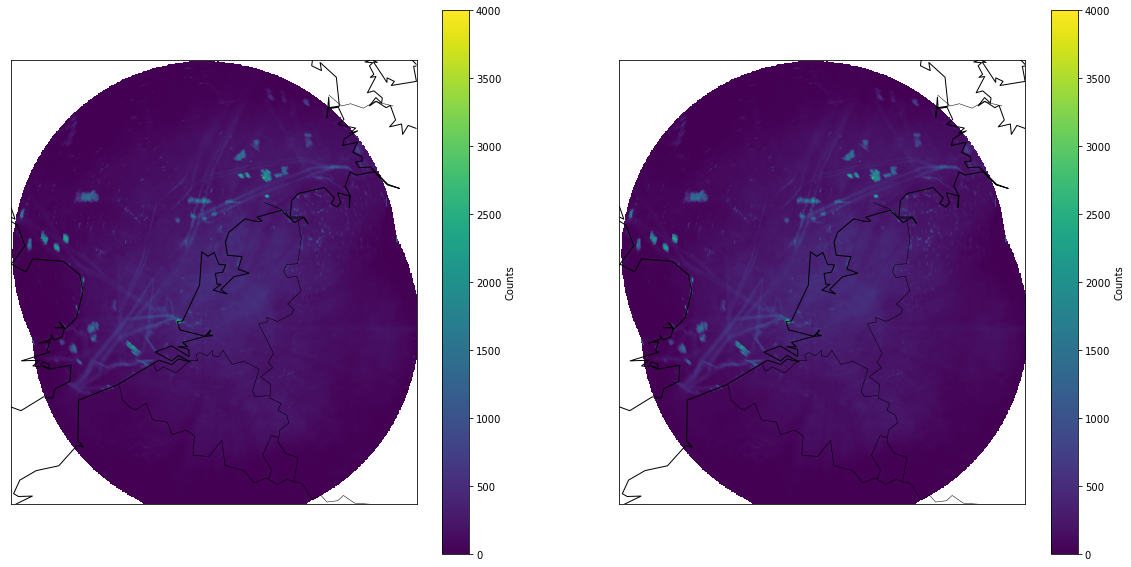

In [77]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
radarplot.plot_on_map(cltr[0], ftype='.h5', vmax=4000)
plt.subplot(1,2,2)
radarplot.plot_on_map(count_exceed[0], ftype='.h5', vmax=4000)

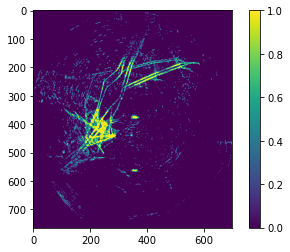

In [38]:
plt.imshow(-count_exceed[0]+cltr[0]>5,vmin=-0.001)
plt.colorbar()

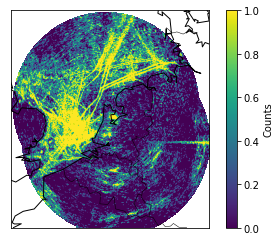

In [71]:
radarplot.plot_on_map(cltr[0]-count_exceed[0]>0, ftype='.h5')

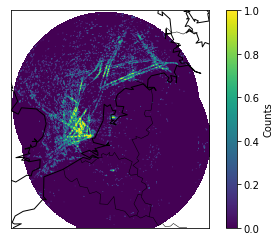

In [23]:
radarplot.plot_on_map(cltr[1]-count_exceed[1]>0, ftype='.h5')

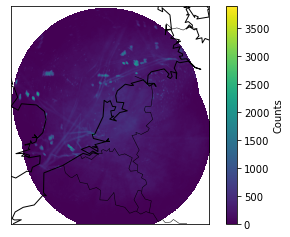

In [13]:
radarplot.plot_on_map(count_exceed[0], ftype='.h5')

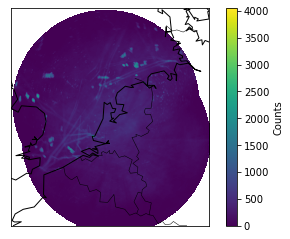

In [14]:
radarplot.plot_on_map(cltr[0], ftype='.h5')

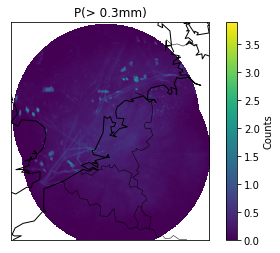

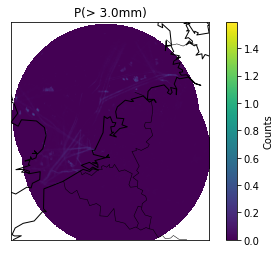

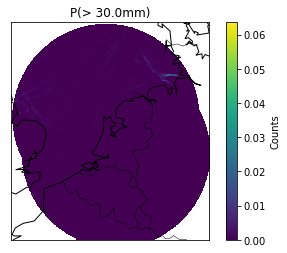

In [10]:
cltr = np.load('rtcor_clutter.npy')

for i in range(0,cltr.shape[0]-2):
    radarplot.plot_on_map(100*cltr[i]/len(files), ftype='.h5')
    plt.title('P(> {:.1f}mm)'.format(thresholds[i]/100))
    plt.show()


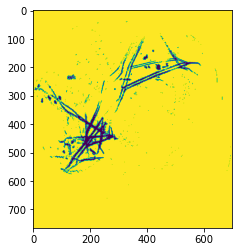

In [12]:
cluttermask = ~np.squeeze(np.load('cluttermask.npy'))
plt.imshow(cluttermask)

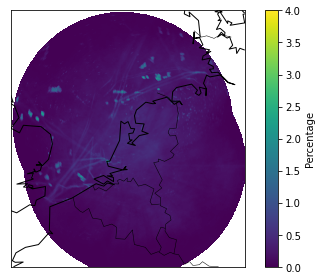

In [29]:
cltr = np.load('rtcor_clutter2.npy')
radarplot.plot_on_map(100*(cltr[0])/len(files), ftype='.h5', value='Percentage',vmax=4)
plt.tight_layout()
plt.savefig('figures/rtcor_raw', bbox_inches = 'tight')

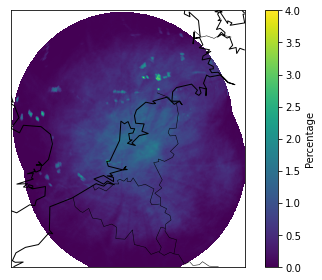

In [30]:
cltr = np.load('rtcor_clutter_removed_small_obj15_rainy.npy')
radarplot.plot_on_map(100*cltr[0]/len(rainy_samples), ftype='.h5', value='Percentage', vmax=4)
plt.tight_layout()
plt.savefig('figures/rtcor_rainy', bbox_inches = 'tight')

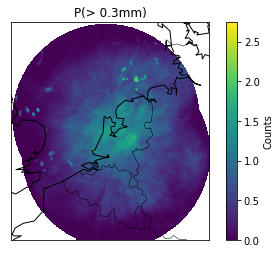

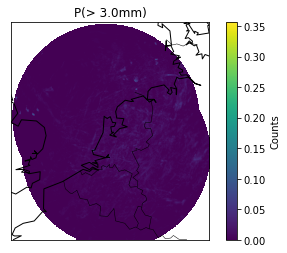

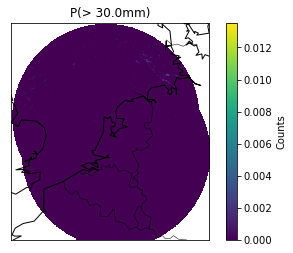

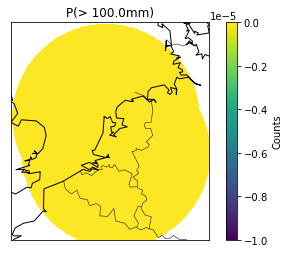

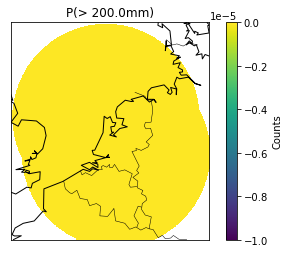

In [26]:
cltr = np.load('rtcor_clutter_removed_small_obj15_rainy.npy')

for i in range(0,cltr.shape[0]):
    radarplot.plot_on_map(100*cltr[i]/len(rainy_samples), ftype='.h5')
    plt.title('P(> {:.1f}mm)'.format(thresholds[i]/100))
    plt.show()


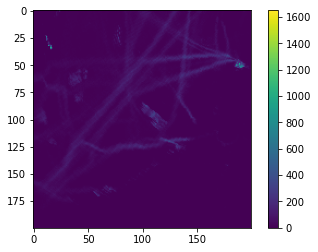

In [396]:
plt.imshow(cltr[1][400:600,100:300])
plt.colorbar()

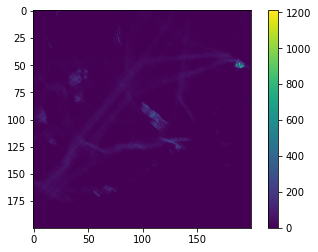

In [6]:
plt.imshow(count_exceed[1][400:600,100:300])
plt.colorbar()

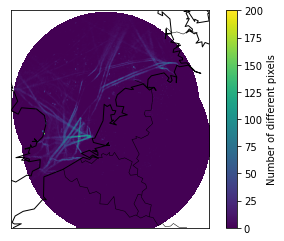

In [31]:
diff = cltr[1] - count_exceed[1]
radarplot.plot_on_map(diff,vmax=200, ftype='.h5', value='Number of different pixels')
plt.savefig('figures/difference_removal_clutter_size15')

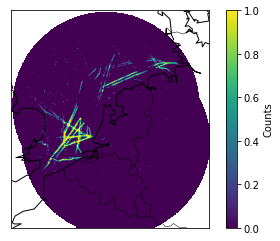

In [29]:
diff = cltr[1] - count_exceed[1]
radarplot.plot_on_map(diff>30, ftype='.h5')

In [390]:
np.where(diff == np.max(diff))

(array([434]), array([116]))

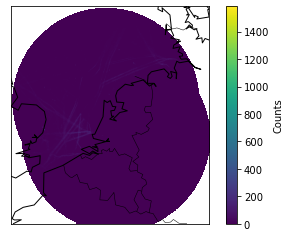

In [399]:
radarplot.plot_on_map(diff, ftype='.h5')

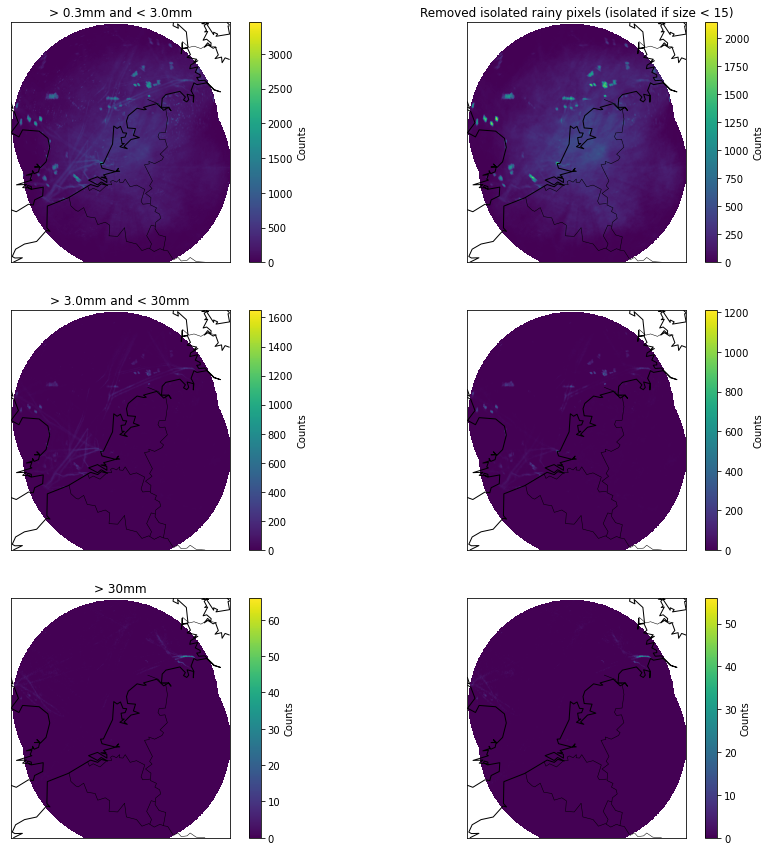

In [374]:
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
radarplot.plot_on_map(cltr[0]-cltr[1], ftype='.h5')
plt.title('> 0.3mm and < 3.0mm')
plt.subplot(3,2,2)
radarplot.plot_on_map(count_exceed[0]-count_exceed[1], ftype='.h5')    
plt.title('Removed isolated rainy pixels (isolated if size < 15)')
plt.subplot(3,2,3)
radarplot.plot_on_map(cltr[1]-cltr[2], ftype='.h5')
plt.title('> 3.0mm and < 30mm')
plt.subplot(3,2,4)
radarplot.plot_on_map(count_exceed[1]-count_exceed[2], ftype='.h5')   
plt.subplot(3,2,5)
radarplot.plot_on_map(cltr[2], ftype='.h5')
plt.title('> 30mm')
plt.subplot(3,2,6)
radarplot.plot_on_map(count_exceed[2], ftype='.h5')    
plt.savefig('figures/clutter_removal_by_size15')

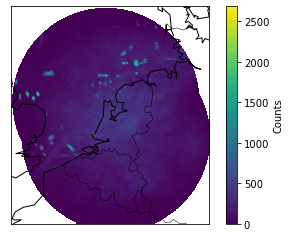

In [353]:
radarplot.plot_on_map(count_exceed[0], ftype='.h5')

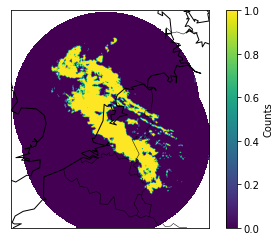

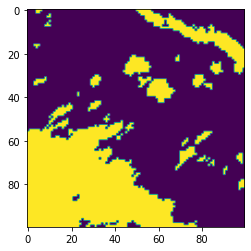

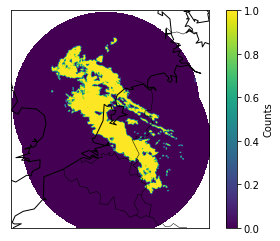

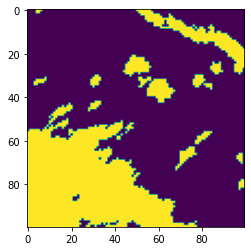

In [318]:
rdr = np.load(radar_dir+'201906060050.npy')
radarplot.plot_on_map(rdr>30, ftype='.h5')
plt.show()
plt.imshow(rdr[400:500,440:540]>30)
plt.show()
cleaned = morphology.remove_small_objects(rdr>30, min_size=10, connectivity=8)
radarplot.plot_on_map(cleaned, ftype='.h5')
plt.show()
plt.imshow(cleaned[400:500,440:540])
plt.show()

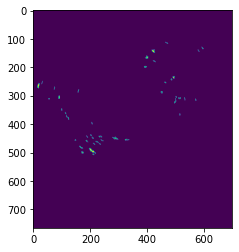

In [326]:
plt.imshow(rdr*cleaned>30)

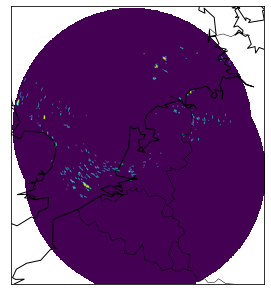

In [37]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
rdr = np.load(radar_dir+'201904080050.npy')
radarplot.plot_on_map(rdr>30, ftype='.h5', colorbar=False)
plt.savefig('figures/clutter_temp')

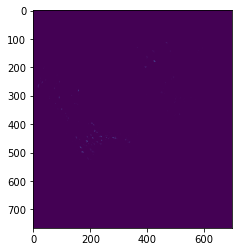

In [52]:
fig, ax = plt.subplots()
ax.imshow(rdr)
ax.add_patch(
     patches.Rectangle(
        (1, 1),
        1,
        2,
        edgecolor = 'blue',
        facecolor = 'red',
        fill=False      
     ) )


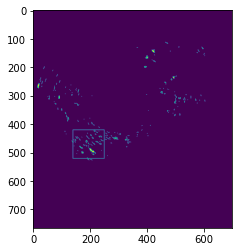

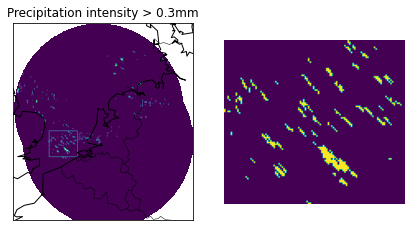

In [70]:
fig = plt.figure()
plt.subplot(1,2,1)
rdr = np.load(radar_dir+'201904080050.npy')
pp = Image.fromarray(rdr>30)
ix = ImageDraw.Draw(pp)
ix.rectangle([(140,420),(250,520)],outline='red') #draw rectangle of 1's on the image
rdr_pil = np.array(pp)

radarplot.plot_on_map(rdr_pil, ftype='.h5', colorbar=False)

plt.title('Precipitation intensity > 0.3mm')
plt.subplot(1,2,2)
plt.imshow(rdr[420:520,140:250]>30)
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/clutter_example', bbox_inches = 'tight')

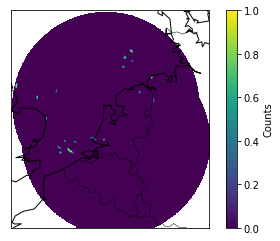

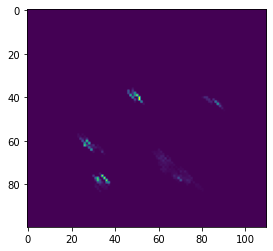

In [23]:
cleaned = morphology.remove_small_objects(rdr>30, min_size=15, connectivity=8)
cleaned = rdr*cleaned
radarplot.plot_on_map(cleaned>30, ftype='.h5')
plt.show()
plt.imshow(cleaned[420:520,140:250])
plt.show()

In [100]:
count_exceed = np.zeros((len(thresholds), 765,700))
count_sum = 0
error_count=0
max_val = 0

hst = []
for f in tqdm(random_files):
    try:
        rdr = np.load(radar_dir+f)
        rdr[rdr == 65535] = 0
        if np.sum(rdr == 65535) > 0:
            print(f)
        if rdr[0][0] != 0:
            print(rdr[0][0])
            
        blur = cv2.blur(slice_rdr, (3,3),1)
        labels, num_label = scipy.ndimage.label(blur, structure = np.ones((3,3)))
        size = np.bincount(label.ravel())
        
        hst.append(size)
    except:
        error_count=+1
        rdr = np.zeros((765,700))
        
    for i, thresh in enumerate(thresholds):
        count_exceed[i] += rdr>thresh
    if np.max(rdr) > max_val:
        max_val=np.max(rdr)
    count_sum += 1


NameError: name 'thresholds' is not defined

In [63]:
print('Errors: ', error_count)
print(max_val)
print(count_sum)

Errors:  0
3789
100


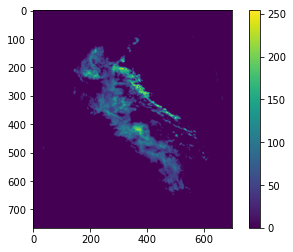

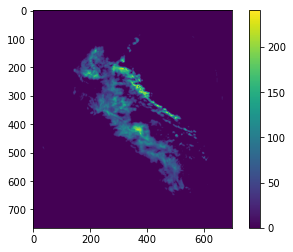

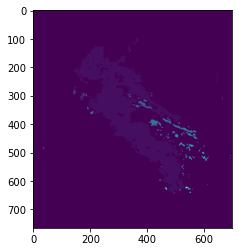

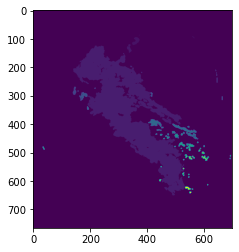

In [93]:
rdr = np.load(radar_dir+'201906060045.npy')
slice_rdr= rdr
plt.imshow(slice_rdr, vmin=0)
plt.colorbar()
plt.show()
blur = cv2.blur(slice_rdr, (3,3),1)
plt.imshow(blur)
plt.colorbar()
plt.show()
label, num_label = scipy.ndimage.label(slice_rdr, structure = np.ones((3,3)))
plt.imshow(label)
plt.show()
labels, num_label = scipy.ndimage.label(blur, structure = np.ones((3,3)))
plt.imshow(labels)

(array([135.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.00000e+00, 5.68880e+03, 1.13756e+04, 1.70624e+04, 2.27492e+04,
        2.84360e+04, 3.41228e+04, 3.98096e+04, 4.54964e+04, 5.11832e+04,
        5.68700e+04]),
 <a list of 10 Patch objects>)

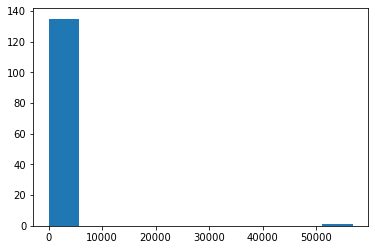

In [99]:
plt.hist(size[1:])

In [94]:
size = np.bincount(label.ravel())
size

array([474704,     10,      7,    310,     25,  56870,     74,     55,
            3,      3,      2,      3,      2,      2,      4,      2,
            2,      4,     16,      9,     20,     14,      4,      8,
           96,      3,    100,      4,      5,     20,     41,      2,
           32,     20,     37,     12,      3,      4,      2,     11,
            2,      4,     15,     67,    338,      5,     18,     14,
           75,     31,     77,      2,      8,    196,      6,      8,
            9,    465,      2,      8,      5,      4,    420,     12,
           11,     15,      9,     43,     16,     12,     82,     51,
            5,     12,     20,     90,     18,      6,     23,     55,
            2,      4,      2,      5,     99,     11,      2,      2,
           74,      5,      2,      7,      4,     20,      9,      3,
           13,      2,      3,     22,     14,      3,     34,      3,
           23,      3,     51,      2,      2,     27,      4,      8,
      

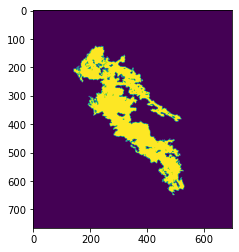

In [87]:
biggest = size[1:].argmax() + 1

big_cloud = (label == biggest)
plt.imshow(big_cloud)

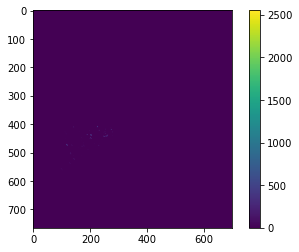

array([535176,      3,      7,      6,      2,      3,      5,      4,
            7,      3,      5,      3,      2,      2,      6,      2,
            2,      2,      4,      5,     11,      5,      2,      9,
            6,      2,      8,      3,      4,      3,      7,      6,
            2,      4,      5,      2,      3,      2,      4,      2,
            6,      2,      2,      4,      3,     12,      4,      7,
           10,      9,     12,      3,      2,      2,      2,      3,
            2,      6,      2,      8,      7,      2,      2,      4,
            3,     11,      5,      3,      3,      9,      7,      4])

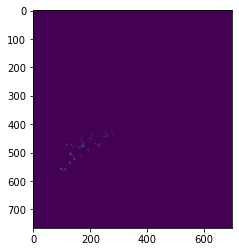

In [91]:
rdr = np.load(radar_dir+'201906062020.npy')

plt.imshow(rdr, vmin=0)
plt.colorbar()
plt.show()
blur = cv2.blur(rdr, (3,3),1)
plt.imshow(blur)
labels, num_label = scipy.ndimage.label(rdr, structure = np.ones((3,3)))
plt.imshow(labels)
size = np.bincount(labels.ravel())
size 

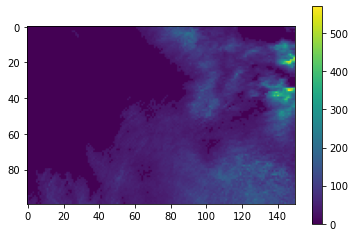

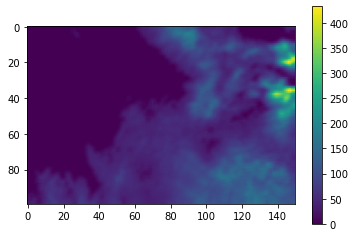

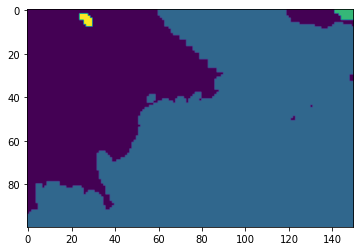

In [54]:
rdr = np.load(radar_dir+'201906060005.npy')
slice_rdr= rdr[300:400,200:350]
plt.imshow(slice_rdr, vmin=0)
plt.colorbar()
plt.show()
blur = cv2.blur(slice_rdr, (3,3),1)
plt.imshow(blur)
plt.colorbar()
plt.show()
label, num_label = scipy.ndimage.label(blur, structure = np.ones((3,3)))
plt.imshow(label)
plt.show()

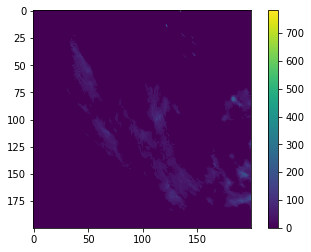

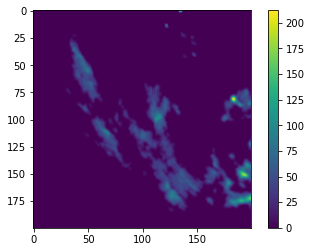

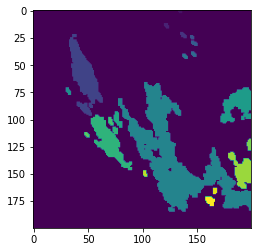

In [15]:
rdr = np.load(radar_dir+'201906052020.npy')
slice_rdr= rdr[400:600,100:300]
plt.imshow(slice_rdr, vmin=0)
plt.colorbar()
plt.show()
blur = cv2.blur(slice_rdr, (3,3),1)
plt.imshow(blur)
plt.colorbar()
plt.show()
label, num_label = scipy.ndimage.label(blur, structure = np.ones((3,3)))
plt.imshow(label)
plt.show()

In [26]:
label, num_label = scipy.ndimage.label(blur, structure = np.ones((3,3)))

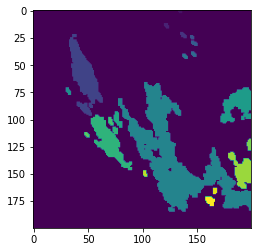

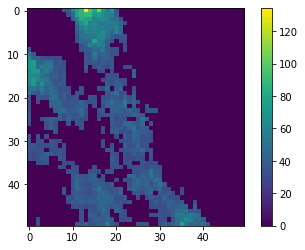

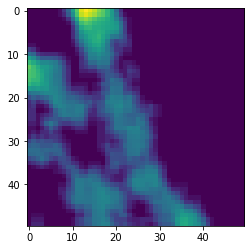

In [262]:
rdr = np.load(radar_dir+'201906052020.npy')
slice_rdr= rdr[500:550,200:250]
plt.imshow(slice_rdr, vmin=0)
plt.colorbar()
plt.show()
blur = cv2.blur(slice_rdr, (3,3),1)
plt.imshow(blur)

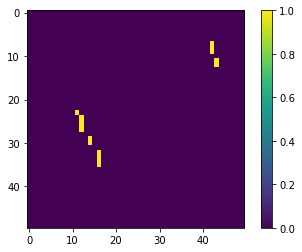

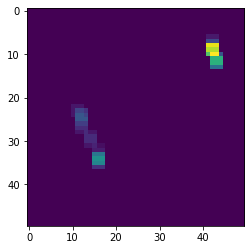

In [124]:
rdr = np.load(radar_dir+'201906062020.npy')
slice_rdr= rdr[400:450,100:150]
plt.imshow(slice_rdr>0, vmin=0)
plt.colorbar()
plt.show()
blur = cv2.blur(slice_rdr, (3,3),1)
plt.imshow(blur)

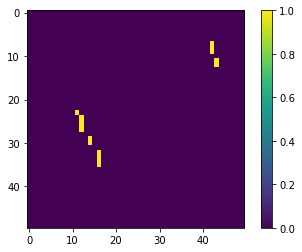

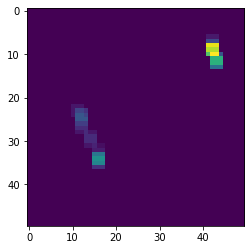

In [263]:
rdr = np.load(radar_dir+'201906062020.npy')
slice_rdr= rdr[400:450,100:150]
plt.imshow(slice_rdr>0, vmin=0)
plt.colorbar()
plt.show()
blur = cv2.blur(slice_rdr, (3,3),1)
plt.imshow(blur)

  0%|          | 0/5 [00:00<?, ?it/s]

0


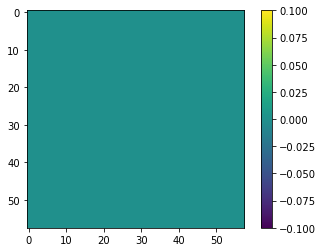

 20%|██        | 1/5 [00:00<00:00,  8.85it/s]

3654


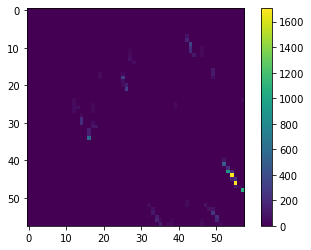

 40%|████      | 2/5 [00:00<00:00,  9.03it/s]

1524


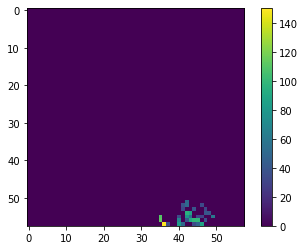

 60%|██████    | 3/5 [00:00<00:00,  9.22it/s]

87


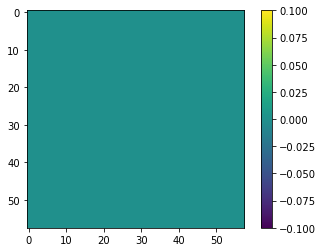

 80%|████████  | 4/5 [00:00<00:00,  9.22it/s]

74


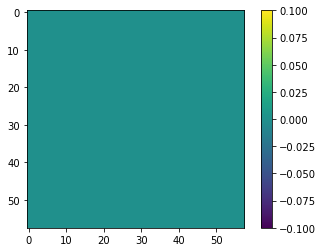

100%|██████████| 5/5 [00:00<00:00,  9.18it/s]


In [247]:
starti=1000
for f in tqdm(random_files[starti:starti+5]):
    rdr = np.load(radar_dir+f)
    slice_rdr = rdr[400:458,100:158]
    plt.imshow(slice_rdr, vmin=0)
    print(np.max(rdr))
    plt.colorbar()
    plt.show()

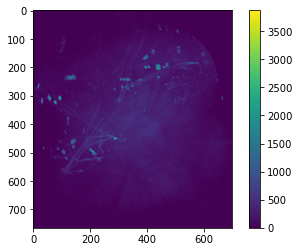

In [83]:
plt.imshow(count_exceed[0])
plt.colorbar()

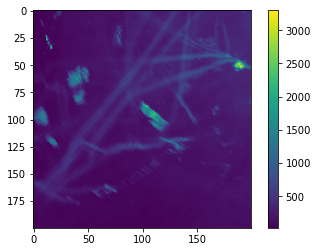

In [87]:
plt.imshow(count_exceed[0][400:600,100:300])
plt.colorbar()

In [6]:
np.save('rtcor_clutter2.npy', count_exceed)

In [236]:
diff[diff < 0]

array([-1., -1., -1.])

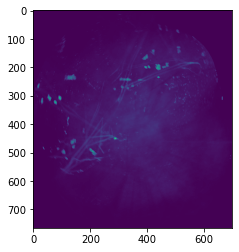

25146


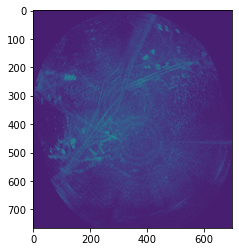

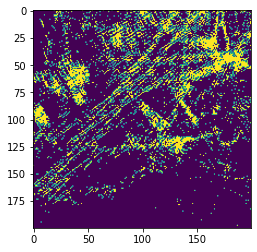

In [237]:
count_exceed1 = np.load('rtcor_clutter.npy')
count_exceed2 = np.load('rtcor_clutter2.npy')
diff = count_exceed1[0]-count_exceed2[0]
plt.imshow(np.log(diff+2))
print(np.sum(diff>10))
plt.show()
plt.imshow(diff[400:600,100:300]>10)
plt.show()

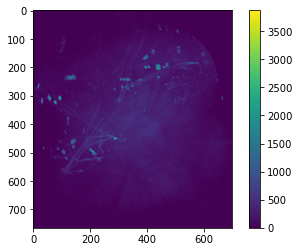

In [78]:
count_exceed = np.load('rtcor_clutter2.npy')
cmap = cm.viridis
plt.imshow(count_exceed[0], cmap='viridis', vmin=-0.000000001)
plt.colorbar()

In [60]:
def plot_on_map(rdr, ftype='.nc', res='l'):
    '''
    Plot radar file on top of map.
    rdr: image file
    res: resolution, can be c (crude), l (low), i (intermediate), h (high), f (full) 
    '''
    
    dir_aart = '/nobackup_1/users/schreurs/project_GAN/dataset_aart/'
    aart_fbase = 'RAD_NL25_RAC_MFBS_EM_5min_'
    
    proj = Proj("+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378.137 +b=6356.752 +x_0=0 +y_0=0")
    
    # All images are plotted on the same map
    # Get the map from random nc file
    path = dir_aart + aart_fbase + '201901010000.nc'
    with netCDF4.Dataset(path, 'r') as ds:
        # Get coordinates of the pixels
        xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
        lon, lat = proj(xx, yy, inverse=True)
        # Plot values on map
        iso_dict = ds['iso_dataset'].__dict__
        min_x = float(iso_dict['min_x'].replace('f', ''))
        min_y = float(iso_dict['min_y'].replace('f', ''))
        max_x = float(iso_dict['max_x'].replace('f', ''))
        max_y = float(iso_dict['max_y'].replace('f', ''))
        
        if ftype == '.nc':
            rain = ds['image1_image_data'][:]
            mask = rain.mask
    
    if  ftype == '.h5':
        dir_rtcor = '/nobackup_1/users/schreurs/project_GAN/dataset_radar/'
        rtcor_fbase = 'RAD_NL25_RAC_RT_'
        path = dir_rtcor + rtcor_fbase + '201901010000.h5'
        with h5py.File(path, 'r') as f:
                rain = f['image1']['image_data'][:]
                mask = (rain == 65535)

    
    # Mask the data
    print(np.sum(~mask))
    mx = np.ma.masked_array(rdr, mask)
    # Plot the precipitation on map  
    mp = Basemap(projection='stere',
                         lat_0=90,
                         lon_0=0, 
                         lat_ts=60,   
                         llcrnrlon=min_x,   # lower longitude
                         llcrnrlat=min_y,    # lower latitude
                         urcrnrlon=max_x,   # uppper longitude
                         urcrnrlat=max_y,   # uppper latitude
                         resolution=res
                        )
    mp.drawcoastlines()
    mp.drawstates()
    mp.drawcountries()

    xx, yy = mp(lon, lat)

    vmin=-0.00001    
    cmap = cm.viridis
    plt.imshow(mx, vmin = vmin, cmap=cmap, origin='upper', 
           extent=[xx.min(), xx.max(), yy.min(), yy.max()])
    plt.colorbar()

In [4]:
count_exceed = np.load('rtcor_clutter.npy')

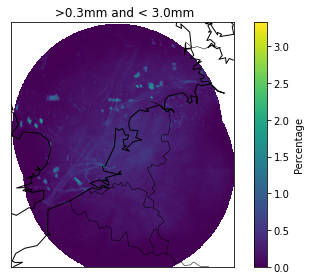

In [87]:
i=0
radarplot.plot_on_map(100*(count_exceed[i]-count_exceed[i+1])/len(files), ftype='.h5', value = 'Percentage')
plt.title(' >{:.1f}mm and < {:.1f}mm'.format(thresholds[i]/100,thresholds[i+1]/100))
plt.tight_layout()
plt.savefig('figures/freq_above_03mm', bbox_inches = 'tight')
plt.show()

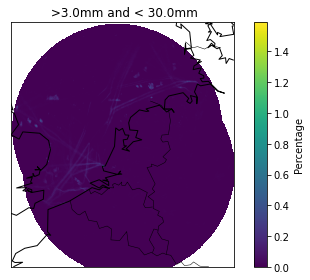

In [94]:
i=1
radarplot.plot_on_map(100*(count_exceed[i]-count_exceed[i+1])/len(files), ftype='.h5', value = 'Percentage')
plt.title(' >{:.1f}mm and < {:.1f}mm'.format(thresholds[i]/100,thresholds[i+1]/100))
plt.tight_layout()
plt.savefig('figures/freq_above_3mm', bbox_inches = 'tight')
plt.show()

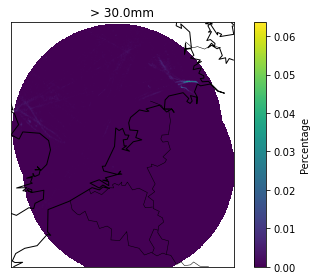

In [97]:
i=2
radarplot.plot_on_map(100*count_exceed[i]/len(files), ftype='.h5',value = 'Percentage')
plt.title('> {}mm'.format(thresholds[i]/100))
plt.tight_layout()
plt.savefig('figures/freq_above_30mm', bbox_inches = 'tight')

<ipython-input-60-7dec693f6444>:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__


430831


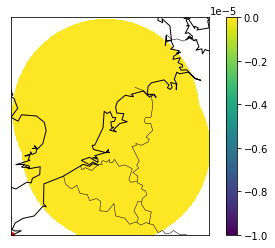

In [62]:
i=3
plot_on_map(count_exceed[i], ftype='.h5')
plt.scatter(19,438,color='r')


In [202]:
np.unique(count_exceed[i])

array([0., 1.])

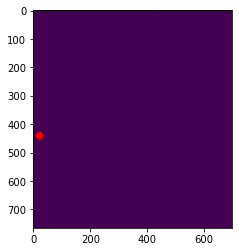

In [217]:
plt.imshow(count_exceed[3], vmin=-0.00001)
plt.scatter(19,438,color='r')
plt.scatter(20,438,color='r')

In [213]:
count_exceed[3][20,440]

1.0

In [208]:
np.where(count_exceed[3] != 0)

(array([19, 20]), array([438, 440]))

In [186]:
ind = np.argmax(count_exceed[i])
np.unravel_index(ind, (765,700))

(19, 438)

<ipython-input-169-4ce9354d1def>:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__


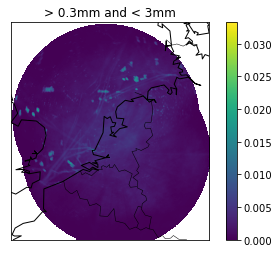

In [288]:
# 0.3mm < x < 3mm:
between = (count_exceed[0] - count_exceed[1])/count_sum

plot_on_map(between, ftype='.h5')
plt.title('> 0.3mm and < 3mm')
plt.savefig('figures/freq_between_03mm_3mm')

In [80]:
count_exceed = np.load('rtcor_clutter.npy')
count_exceed.shape

(5, 765, 700)

<ipython-input-8-4ce9354d1def>:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__


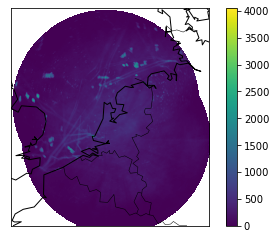

In [10]:
plot_on_map(count_exceed[0], ftype='.h5')

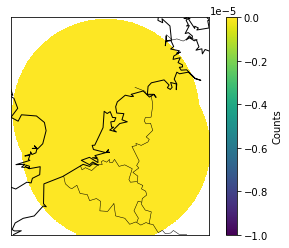

In [105]:
test = count_exceed[0]/len(files)
radarplot.plot_on_map(test1, ftype='.h5')

0.51% of the data


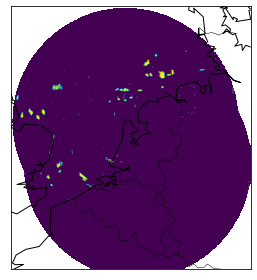

In [72]:

i=0
prob_rain = 100*(count_exceed[i])/len(files)
mask_clutter= prob_rain>1
cmap=cm.viridis
radarplot.plot_on_map(mask_clutter, ftype='.h5',colorbar=False, cmap=cmap)
print('{:.2f}% of the data'.format(100*np.sum(mask_clutter)/(765*700)))
plt.tight_layout()
plt.savefig('figures/mask_prob_1', bbox_inches = 'tight')
plt.show()

np.save('prob1_mask', mask_clutter)

In [2]:
count_exceed2 = np.load('rtcor_clutter_removed_small_obj15.npy')

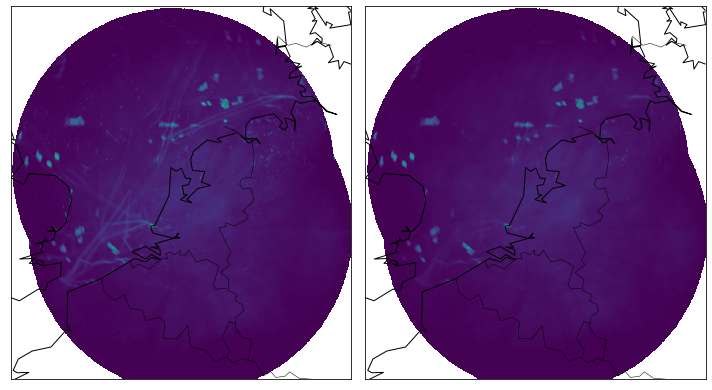

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
radarplot.plot_on_map(count_exceed[0], ftype='.h5', vmax=np.max(count_exceed[0]), colorbar=False)
plt.subplot(1,2,2)
radarplot.plot_on_map(count_exceed2[0], ftype='.h5', vmax=np.max(count_exceed[0]), colorbar=False)
plt.tight_layout()
#plt.savefig('figures/clutter_example', bbox_inches = 'tight')

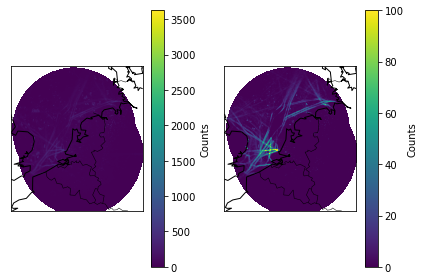

In [117]:
plt.figure()
plt.subplot(1,2,1)
diff = count_exceed[0] - count_exceed2[0]
radarplot.plot_on_map(diff, ftype='.h5')
plt.subplot(1,2,2)
diff = count_exceed[1] - count_exceed2[1]
radarplot.plot_on_map(diff, ftype='.h5', vmax=100)
plt.tight_layout()

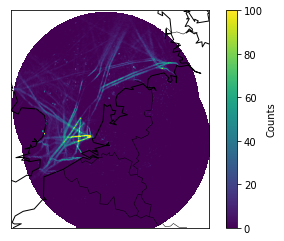

3.939595804387335


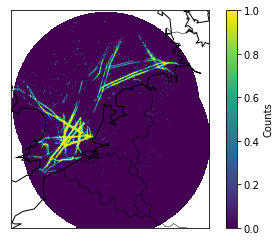

In [90]:
n=15
print(100*np.sum(diff>n)/(430831))
radarplot.plot_on_map(diff>n, ftype='.h5')

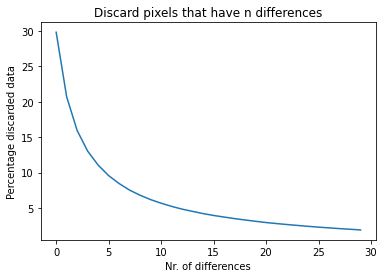

## Look at only rainy (aart) days

Previously I looked at the complete data of 1 year. Below I will look at only the days that are labeled as rainy. I will use the labels based on Aart dataset for this. This dataset has less clutter.

In [78]:
label_dir = '/nobackup_1/users/schreurs/project_GAN/aart_rain_labels/'
labels = sorted([f for f in listdir(label_dir) if isfile(join(label_dir, f)) and f.startswith('2019')])
print(len(labels))

rainy_days = []
for label in labels:
    norain = np.load(label_dir+label)
    if not norain:
        rainy_days.append(label)
print(len(rainy_days))
print('{:.2f}% of the days are rainy'.format(100*len(rainy_days)/len(labels)))

105119
40235
38.28% of the days are rainy


In [11]:
count_exceed = np.zeros((len(thresholds), 765,700))
count_sum = 0
error_count=0
max_val = 0
for f in tqdm(rainy_days):
    try:
        rdr = np.load(radar_dir+f)
        rdr[rdr == 65535] = 0
        if np.sum(rdr == 65535) > 0:
            print(f)
        if rdr[0][0] != 0:
            print(rdr[0][0])
    except:
        error_count=+1
        rdr = np.zeros((765,700))
        
    for i, thresh in enumerate(thresholds):
        count_exceed[i] += rdr>thresh
    if np.max(rdr) > max_val:
        max_val=np.max(rdr)
    count_sum += 1

100%|██████████| 40235/40235 [08:55<00:00, 75.14it/s] 


In [13]:
max_val

52254

In [117]:
np.save('rtcor_clutter_rainydays.npy',count_exceed)

In [3]:
count_exceed = np.load('rtcor_clutter.npy')

In [77]:
count_exceed = np.load('rtcor_clutter_rainydays.npy')
count_exceed.shape

(5, 765, 700)

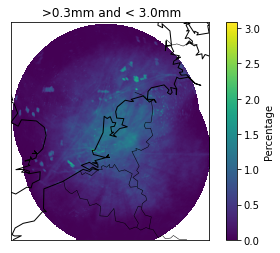

In [79]:
i=0
radarplot.plot_on_map(100*(count_exceed[i]-count_exceed[i+1])/len(rainy_days), ftype='.h5', value = 'Percentage')
plt.title(' >{:.1f}mm and < {:.1f}mm'.format(thresholds[i]/100,thresholds[i+1]/100))
plt.savefig('figures/rainydays_freq_03mm')
plt.show()

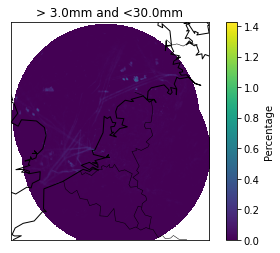

In [14]:
i=1
radarplot.plot_on_map(100*(count_exceed[i]-count_exceed[i+1])/len(rainy_days), ftype='.h5', value = 'Percentage')
plt.title('> {}mm and <{}mm'.format(thresholds[i]/100,thresholds[i+1]/100))
plt.savefig('figures/rainydays_freq_3mm')
plt.show()

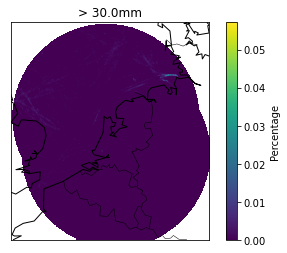

In [17]:
i=2
radarplot.plot_on_map(100*count_exceed[i]/len(rainy_days), ftype='.h5', value='Percentage')
plt.title('> {:.1f}mm'.format(thresholds[i]/100,thresholds[i+1]/100))
plt.savefig('figures/rainydays_freq_30mm')
plt.show()

In [22]:
unmasked_pixels = 430831

In [18]:
430831/(765*700) 

0.8045396825396826

Removed 121 pixels out of the 430831 pixels
Kept 99.97% of the data


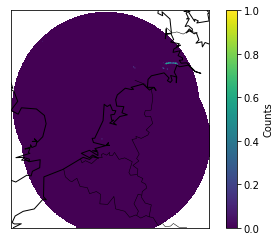

In [24]:
removed = (100*count_exceed[2] /len(rainy_days)) > 0.02
radarplot.plot_on_map(removed, ftype='.h5')
print('Removed {} pixels out of the {} pixels'.format(np.sum(removed), unmasked_pixels))
print('Kept {:.2f}% of the data'.format(100*(unmasked_pixels - np.sum(removed))/unmasked_pixels))

Threshold:  300


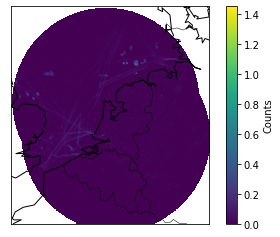

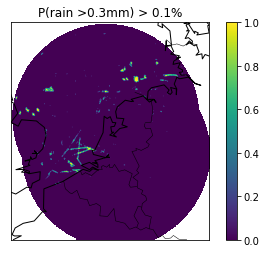

Removed 3370 pixels out of the 430831 pixels
Kept 99.22% of the data


In [33]:
i=1
print('Threshold: ', thresholds[i])
radarplot.plot_on_map(100*(count_exceed[i] /len(rainy_days)), ftype='.h5')
plt.show()
removed1 = (100*count_exceed[i] /len(rainy_days)) > 0.1
radarplot.plot_on_map(removed1, ftype='.h5',value='')
plt.title('P(rain >0.3mm) > 0.1%')
plt.savefig('figures/removal')
plt.show()
print('Removed {} pixels out of the {} pixels'.format(np.sum(removed1), unmasked_pixels))
print('Kept {:.2f}% of the data'.format(100*(unmasked_pixels - np.sum(removed1))/unmasked_pixels))

3370
3370
121


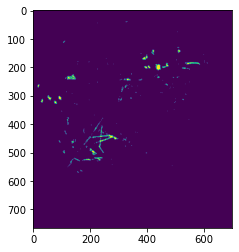

In [115]:
removed_total = removed + removed1
plt.imshow(removed_total)
print(np.sum(removed_total))
print(np.sum(removed1))
print(np.sum(removed))

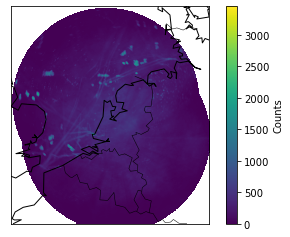

In [14]:
count_exceed = np.load('rtcor_clutter.npy')
radarplot.plot_on_map(count_exceed[0]-count_exceed[1], ftype='.h5')

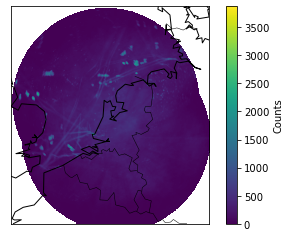

In [12]:
count_exceed2 = np.load('rtcor_clutter2.npy')
radarplot.plot_on_map(count_exceed2[0], ftype='.h5')
plt.title(' >{:.1f}mm and < {:.1f}mm'.format(thresholds[i]/100,thresholds[i+1]/100))
plt.savefig('figures/rainydays_freq_03mm')
plt.show()